In [1]:
import sys
print(sys.version)

2.7.15 |Anaconda, Inc.| (default, May  1 2018, 18:37:05) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
import matplotlib.pyplot as plt

import halotools


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

# COSMOS SMF

Deep sample (not the UD sample) because we need the full COSMOS area to get a signal.

Catalog: http://iopscience.iop.org/article/10.3847/0067-0049/224/2/24/pdf

Cuts: 
- Mass below 10^9
- z between z=0.1 and z=0.4

Some numbers regarding our sample:
- Number of dwarfs :        6876
- Mean mass :      8.52695
- Mean Redshift :     0.301442
- N objects with specz :        1153
- fraction :    0.167685

In [3]:
#first quick&dirty SMF in COSMOS at z~0.2
cosmos_SMF_fit_file='Data/cosmos/mf_mass2b_fl5b_tot_VmaxFit2D0.dat'
cosmos_SMF_points_file='Data/cosmos/mf_mass2b_fl5b_tot_Vmax0.dat'

In [4]:
#final SMF in COSMOS at z~0.2
cosmos_SMF_fit_file='Data/cosmos/cosmos2015_dic2017_smf_z01-04_STY0.dat'
cosmos_SMF_points_file='Data/cosmos/cosmos2015_dic2017_smf_z01-04_Vmax0.dat'
cosmos_SMF_fit_table=ascii.read(cosmos_SMF_fit_file)
cosmos_SMF_points_table=ascii.read(cosmos_SMF_points_file)


print(cosmos_SMF_fit_table)
print(cosmos_SMF_points_table)

  log_m      log_phi   log_phi_inf log_phi_sup
---------- ----------- ----------- -----------
       0.0   0.9907256   1.0965684   0.8843038
       0.1   0.9593335   1.0640014   0.8540923
       0.2   0.9279413   1.0314345   0.8238808
       0.3   0.8965492   0.9988675   0.7936693
       0.4    0.865157   0.9663005   0.7634578
       0.5   0.8337649   0.9337335   0.7332463
       0.6   0.8023727   0.9011666   0.7030348
       0.7   0.7709806   0.8685996   0.6728233
       0.8   0.7395884   0.8360326   0.6426118
       0.9   0.7081963   0.8034657   0.6124003
       ...         ...         ...         ...
28.9000004 999.9000244 999.9000244 999.9000244
29.0000004 999.9000244 999.9000244 999.9000244
29.1000004 999.9000244 999.9000244 999.9000244
29.2000004 999.9000244 999.9000244 999.9000244
29.3000004 999.9000244 999.9000244 999.9000244
29.4000004 999.9000244 999.9000244 999.9000244
29.5000004 999.9000244 999.9000244 999.9000244
29.6000004 999.9000244 999.9000244 999.9000244
29.7000004 99

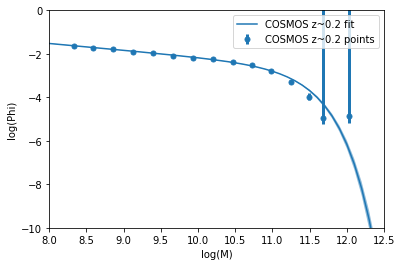

In [5]:
plt.plot(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi'], label='COSMOS z~0.2 fit')
plt.fill_between(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi_inf'], 
                 cosmos_SMF_fit_table['log_phi_sup'], alpha=0.5)
plt.errorbar(cosmos_SMF_points_table['col1'], cosmos_SMF_points_table['col2'], 
             yerr=[cosmos_SMF_points_table['col3'],cosmos_SMF_points_table['col4']], fmt='o', elinewidth=3,
            markersize=5, c='#1f77b4', label='COSMOS z~0.2 points')

plt.xlabel('log(M)')
plt.ylabel('log(Phi)')
plt.xlim([8,12.5])
plt.ylim([-10,0])
plt.legend()
plt.show()

# Abundance Matching with variable scatter

Pick a set of parameter for the PB model and do abundance matching wth variable scatter, and compare the COSMS SMF with the model SMF.


## read in halo catalog

In [6]:
#halotools catalog

halo_cat_file='Data/hlist_0.78209.list'
#scale(0) id(1) desc_scale(2) desc_id(3) num_prog(4) pid(5) upid(6) desc_pid(7) phantom(8) sam_mvir(9) mvir(10)
#rvir(11) rs(12) vrms(13) mmp?(14) scale_of_last_MM(15) vmax(16) x(17) y(18) z(19) vx(20) vy(21) vz(22) Jx(23) Jy(24) 
#Jz(25) Spin(26) Breadth_first_ID(27) Depth_first_ID(28) Tree_root_ID(29) Orig_halo_ID(30) Snap_num(31) 
#Next_coprogenitor_depthfirst_ID(32) Last_progenitor_depthfirst_ID(33) Last_mainleaf_depthfirst_ID(34) Tidal_Force(35)
#Tidal_ID(36) Rs_Klypin(37) Mvir_all(38) M200b(39) M200c(40) M500c(41) M2500c(42) Xoff(43) Voff(44) Spin_Bullock(45) 
#b_to_a(46) c_to_a(47) A[x](48) A[y](49) A[z](50) b_to_a(500c)(51) c_to_a(500c)(52) A[x](500c)(53) A[y](500c)(54) 
#A[z](500c)(55) T/|U|(56) M_pe_Behroozi(57) M_pe_Diemer(58) Macc(59) Mpeak(60) Vacc(61) Vpeak(62) Halfmass_Scale(63) 
#Acc_Rate_Inst(64) Acc_Rate_100Myr(65) Acc_Rate_1*Tdyn(66) Acc_Rate_2*Tdyn(67) Acc_Rate_Mpeak(68) Mpeak_Scale(69) 
#Acc_Scale(70) First_Acc_Scale(71) First_Acc_Mvir(72) First_Acc_Vmax(73) Vmax@Mpeak(74) Tidal_Force_Tdyn(75) 
#Log_(Vmax/Vmax_Tdyn)(76)


In [7]:
from halotools.sim_manager import TabularAsciiReader
from halotools.sim_manager.rockstar_hlist_reader import RockstarHlistReader
#python 3 gives error about converting unicode 'TypeError: No conversion path for dtype: dtype('<U12')'

output_fname = 'Data/hlist_0.78209.hdf5'
columns_to_keep_dict = {'halo_id': (1, 'i8'), 'halo_upid': (6, 'i8'), 'halo_mvir': (10, 'f4'), 'halo_x': (17, 'f4'), 
                        'halo_y': (18, 'f4'), 'halo_z': (19, 'f4'),'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 
                        'halo_vz': (22, 'f4'), 'halo_rvir': (11, 'f4'), 'halo_mpeak': (60, 'f4')}

#is there a way to read in all columns? NO

simname = 'bolshoi-planck'
halo_finder = 'rockstar'
version_name = 'bplanck_dwarfs'
ptcl_version_name='bplanck_dwarfs_downsampled2'
ptcl_version_name='bplanck_dwarfs'

redshift = 0.278625 #(1/0.78209)-1 ; a=0.78209
Lbox, particle_mass = 250, 1.5e8

## Read in local file as halo catalog

In [8]:
# reader = RockstarHlistReader(halo_cat_file, columns_to_keep_dict, output_fname, simname, halo_finder, redshift, 
#                              version_name, Lbox, particle_mass, overwrite=True) # doctest: +SKIP
# reader.read_halocat(['halo_rvir'], write_to_disk = True, update_cache_log = True) # doctest: +SKIP

In [9]:
# #explore with h5py
# import h5py
# # Load file
# f = h5py.File('Data/hlist_0.78209.hdf5', 'r')

# #HDF files have attributes: metadata attached to the whole dataset
# print('Attribute keys : ', f.attrs.keys())
# #Then there is the actual data, which is also called with keywords 
# print('Dataset keys : ', f.keys())

# f['data'].value


In [8]:
#The halo catalog is now stored in cache and can be loaded into memory at any time
from halotools.sim_manager import HaloTableCache, CachedHaloCatalog
cache = HaloTableCache()

#list cache entries
for entry in cache.log: 
    print(entry) 
    
#read in halocat    
halocat = CachedHaloCatalog(simname = simname, halo_finder = halo_finder, 
                            version_name = version_name, redshift = redshift, ptcl_version_name=ptcl_version_name) # doctest: +SKIP

print(halocat.redshift) # doctest: +SKIP
print(halocat.ptcl_version_name) # doctest: +SKIP

       

('bolplanck', 'rockstar', 'halotools_v0p4', '0.4966', '/Users/fardila/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_0.66818.list.halotools_v0p4.hdf5')
('bolshoi', 'rockstar', 'halotools_v0p4', '-0.0003', '/Users/fardila/.astropy/cache/halotools/halo_catalogs/bolshoi/rockstar/hlist_1.00035.list.halotools_v0p4.hdf5')
('bolshoi-planck', 'rockstar', 'bplanck_dwarfs', '0.2786', 'Data/hlist_0.78209.hdf5')
0.2786
bplanck_dwarfs


## abundance match with variable scatter

In [9]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory
model = PrebuiltSubhaloModelFactory('behroozi10', redshift=redshift, 
                                    scatter_abscissa=[12, 15], scatter_ordinates=[0.4, 0.2])
model.populate_mock(halocat)
print(model.mock.galaxy_table[0:9])

halo_upid  halo_hostid     halo_mpeak    ...    vz    galid  stellar_mass 
---------- ----------- ----------------- ... -------- ----- --------------
        -1  2404371171 162700000000000.0 ...  -118.07     0 102521210000.0
2404371171  2404371171      6819000000.0 ...   484.04     1       708514.8
2404371171  2404371171      5889000000.0 ...  -214.14     2      2282245.8
2404371171  2404371171      5734000000.0 ...  -795.51     3      1304381.8
2404371171  2404371171      3254000000.0 ...  -213.05     4      29595.826
2404371171  2404371171     73760000000.0 ... -1119.11     5     94193460.0
2404371171  2404371171      1085000000.0 ...  -633.85     6      603.05347
2404371171  2404371171      4959000000.0 ...  1374.05     7      679640.56
2404371171  2404371171       929800000.0 ...  -591.06     8       31870.21


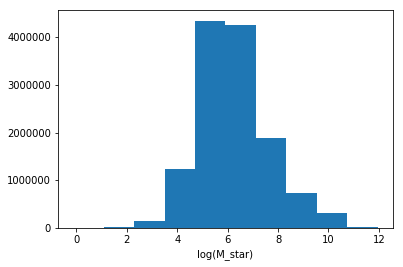

In [10]:
plt.hist(np.log10(model.mock.galaxy_table['stellar_mass']))
plt.xlabel('log(M_star)')
plt.show()

In [11]:
model.param_dict
#model._haloprop_list

{u'scatter_model_param1': 0.4,
 u'scatter_model_param2': 0.2,
 u'smhm_beta_0': 0.43,
 u'smhm_beta_a': 0.18,
 u'smhm_delta_0': 0.56,
 u'smhm_delta_a': 0.18,
 u'smhm_gamma_0': 1.54,
 u'smhm_gamma_a': 2.52,
 u'smhm_m0_0': 10.72,
 u'smhm_m0_a': 0.59,
 u'smhm_m1_0': 12.35,
 u'smhm_m1_a': 0.3}

In [12]:
#calculate smf
#Bolshoi volume was 250h^(-1)Mpc on each side https://www.cosmosim.org/cms/simulations/bolshoip/

M     = model.mock.galaxy_table['stellar_mass']         #Read stellar masses
logM  = np.log10(M)                     #Take logarithm
nbins = 100                             #Number of bins to divide data into
V     = (250/0.7)**3                    #Survey volume in Mpc3
Phi,edg = np.histogram(logM,bins=nbins) #Unnormalized histogram and bin edges
dM    = edg[1] - edg[0]                 #Bin size
centers   = edg[0:-1] + dM/2.           #Mass axis
Phi   = Phi / float(V) / dM             #Normalize to volume and bin size
logPhi= np.log10(Phi)


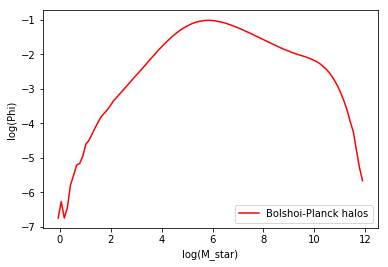

In [13]:
plt.plot(centers,logPhi, c='r', label='Bolshoi-Planck halos')
plt.xlabel('log(M_star)')
plt.ylabel('log(Phi)')
plt.legend()
plt.show()

# plot both SMFs

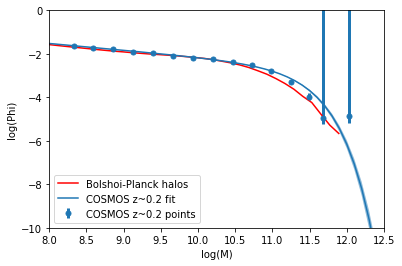

In [14]:
plt.plot(centers,logPhi, c='r', label='Bolshoi-Planck halos')
plt.plot(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi'], label='COSMOS z~0.2 fit')
plt.fill_between(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi_inf'], 
                 cosmos_SMF_fit_table['log_phi_sup'], alpha=0.5)
plt.errorbar(cosmos_SMF_points_table['col1'], cosmos_SMF_points_table['col2'], 
             yerr=[cosmos_SMF_points_table['col3'],cosmos_SMF_points_table['col4']], fmt='o', elinewidth=3,
            markersize=5, c='#1f77b4', label='COSMOS z~0.2 points')

plt.xlabel('log(M)')
plt.ylabel('log(Phi)')
plt.xlim([8,12.5])
plt.ylim([-10,0])
plt.legend(loc='lower left')
plt.show()

Questions: the abundance matching does not use the data for anything...should it?
Answer: No, the data will come into play when doing the MCMC

# Compute the lensing

* Read in the DM particles, x, y,z (manually)
* Precompute the lensing
* Then compute the lensing for the model above (plot the model Delta Sigma verus R)
* Then compare the lensing with the data

## read in DM particle positions

In [17]:
# px = model.mock.ptcl_table['x']
# py = model.mock.ptcl_table['y']
# pz = model.mock.ptcl_table['z']
# particles = np.vstack((px, py, pz)).T

In [15]:
from astropy.table import Table

ptcl_table = Table.read('Data/bplanck/bplanck_particles_100m_a0.78209.hdf5', path='data')

px = ptcl_table['x']
py = ptcl_table['y']
pz = ptcl_table['z']
particles = np.vstack((px, py, pz)).T

## read in galaxy positions

In [16]:
x = model.mock.galaxy_table['x']
y = model.mock.galaxy_table['y']
z = model.mock.galaxy_table['z']
galaxies = np.vstack((x, y, z)).T

In [17]:
print len(galaxies)
print len(particles)

12939617
99993334


### Make cut in mass

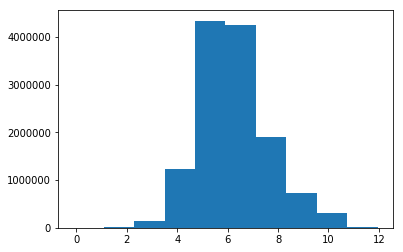

In [18]:
plt.hist(np.log10(model.mock.galaxy_table['stellar_mass']))
plt.show()


In [19]:
galaxies_table=model.mock.galaxy_table[np.log10(model.mock.galaxy_table['stellar_mass'])>10]

In [20]:
len(galaxies_table)

170298

### read in again with mass cut

In [21]:
x = galaxies_table['x']
y = galaxies_table['y']
z = galaxies_table['z']
galaxies = np.vstack((x, y, z)).T

# precompute lensing


### downsample

In [76]:
from halotools.utils import randomly_downsample_data
num_ptcls_to_use = int(1e4)
particles = randomly_downsample_data(particles, num_ptcls_to_use)
particle_masses = np.zeros(num_ptcls_to_use) + halocat.particle_mass

#need to account for the fact that you are not using the entire snapshot of particles by providing the downsampling_factor argument:
halocat.num_ptcl_per_dim=2048 #for bolshoi-planck : https://github.com/astropy/halotools/blob/master/halotools/sim_manager/supported_sims.py
total_num_ptcl_in_snapshot = halocat.num_ptcl_per_dim**3
downsampling_factor = total_num_ptcl_in_snapshot/float(len(particles))

#same bins as data
rp_bins = np.logspace(-2, 0, 9)
# range = [0.01,1.0] #Correlation range
# nbins = 8 #Number of bins

period = model.mock.Lbox    
    

### calculate the mass enclosed by the cylinders around each galaxy

In [23]:
from halotools.mock_observables import total_mass_enclosed_per_cylinder

mass_encl = total_mass_enclosed_per_cylinder(galaxies, particles, particle_masses, downsampling_factor, rp_bins, period)

#create mask for centrals
# cenmask = model.mock.galaxy_table['gal_type'] == 'centrals'
# cens = galaxies[cenmask]
# mass_encl_cens = mass_encl[cenmask, :]


In [24]:
#cosmology
from astropy.cosmology import LambdaCDM
H0=67.8
Om0=0.307
Ode0=0.693

halocat.cosmology = LambdaCDM(H0, Om0, Ode0)

### delta sigma

In [25]:
from halotools.mock_observables import delta_sigma_from_precomputed_pairs
rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, rp_bins, period, cosmology=halocat.cosmology)
ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2

## plot

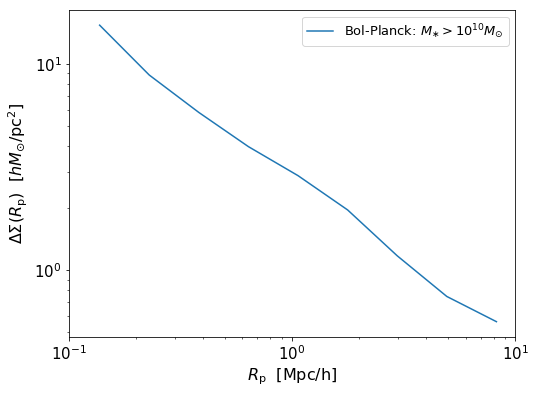

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

__=plt.loglog()

__=ax.plot(rp, ds, label=r'Bol-Planck: $M_{\ast} > 10^{10}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_satellite_in_pc, label=r'Satellites: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_in_pc, label=r'All galaxies: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_central_in_pc, label=r'Centrals: $M_{\ast} \approx 10^{10.5}M_{\odot}$')

__=ax.set_xlim(xmin = 0.1, xmax = 10)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)


plt.show()

## compare with data

Will get distribution of masses from data (COSMOS dwarf galaxies) and match that distribution in simulation galaxies, then use that catalog to calculate lensing signal. Then use MCMC to match lensing signal to measured lensing signal of dwarf galaxies.

Laigle2015 Cosmolgy: H0 = 67.8, Omega_M = 0.307, Omega_L = 0.693.

In [27]:
#lensing signal 
lensing_signal_file = '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/cosmos/dwarf_all_lens_laigle2015_nozp2.out'
dwarf_sample_file = '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/cosmos/dwarf_sample_for_paper.fits'

In [28]:
cosmos_lensing_signal = ascii.read(lensing_signal_file)
print cosmos_lensing_signal

  R(Mpc)  SigR(Msun/pc^2) err(weights) ... Nsources    <R>        e2    
--------- --------------- ------------ ... -------- --------- ----------
0.0133352      58.8677431   17.3327507 ...     2176 0.0142079 -5.3672735
0.0237137      11.8954158    9.6261485 ...     7082 0.0250451 13.2385548
0.0421697       5.6647874    5.4522923 ...    22133 0.0446207  3.5197639
0.0749894       3.2644803    3.0599847 ...    70223 0.0791256  1.1381985
0.1333521       3.9288803    1.7389203 ...   217526 0.1406552 -2.5727109
0.2371374       3.5901829    0.9840321 ...   679967 0.2502264  1.6006856
0.4216965       1.4727592    0.5573089 ...  2120184 0.4446665 -0.0681996
0.7498942       2.5547892    0.3172553 ...  6543536 0.7906795 -0.2700844


In [29]:
cosmos_lensing_signal.colnames

['R(Mpc)',
 'SigR(Msun/pc^2)',
 'err(weights)',
 'err(resampling)',
 'Nsources',
 '<R>',
 'e2']

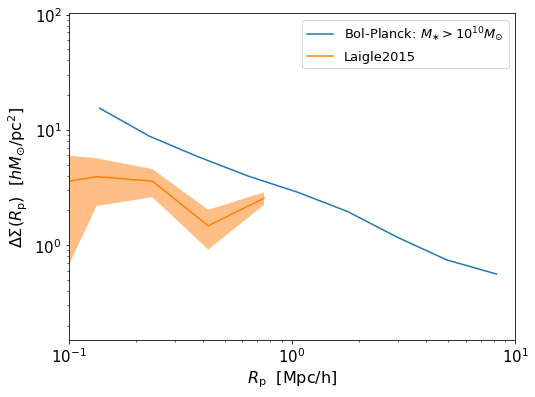

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

__=plt.loglog()

__=ax.plot(rp, ds, label=r'Bol-Planck: $M_{\ast} > 10^{10}M_{\odot}$')
ax.fill_between(rp, ds,ds, alpha=0.5)
# __=ax.plot(rp, result_mstar105_satellite_in_pc, label=r'Satellites: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_in_pc, label=r'All galaxies: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_central_in_pc, label=r'Centrals: $M_{\ast} \approx 10^{10.5}M_{\odot}$')

ax.plot(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)'], label=r'Laigle2015')
ax.fill_between(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)']+cosmos_lensing_signal['err(weights)'],
                cosmos_lensing_signal['SigR(Msun/pc^2)']-cosmos_lensing_signal['err(weights)'], alpha=0.5)

__=ax.set_xlim(xmin = 0.1, xmax = 10)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)


plt.show()

## what is weights error??

In [32]:
dwarf_sample_data  = fits.open(dwarf_sample_file)[1].data
print dwarf_sample_data.columns
dwarf_masses = dwarf_sample_data['mass_med']

ColDefs(
    name = 'IDENT'; format = 'J'
    name = 'MAG_AUTO'; format = 'E'
    name = 'FLUX_AUTO'; format = 'E'
    name = 'MAGERR_AUTO'; format = 'E'
    name = 'FLUX_RADIUS'; format = 'E'
    name = 'FLUXERR_AUTO'; format = 'E'
    name = 'KRON_RADIUS'; format = 'E'
    name = 'MU_MAX'; format = 'E'
    name = 'MU_CLASS'; format = 'E'
    name = 'CLEAN'; format = 'I'
    name = 'GOOD'; format = 'I'
    name = 'FLAGS'; format = 'I'
    name = 'SN'; format = 'E'
    name = 'SN_NON_CORR'; format = 'E'
    name = 'FWHM_IMAGE'; format = 'E'
    name = 'ALPHA_J2000'; format = 'D'
    name = 'DELTA_J2000'; format = 'D'
    name = 'X_IMAGE'; format = 'E'
    name = 'Y_IMAGE'; format = 'E'
    name = 'A_IMAGE'; format = 'E'
    name = 'B_IMAGE'; format = 'E'
    name = 'THETA_IMAGE'; format = 'E'
    name = 'PETRO_RADIUS'; format = 'E'
    name = 'D'; format = 'E'
    name = 'E1_R'; format = 'E'
    name = 'E2_R'; format = 'E'
    name = 'E1_RU'; format = 'E'
    name = 'E2_RU'; format = '

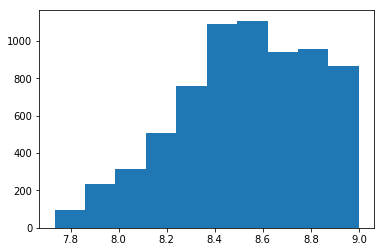

In [33]:
plt.hist(dwarf_masses)
plt.show()

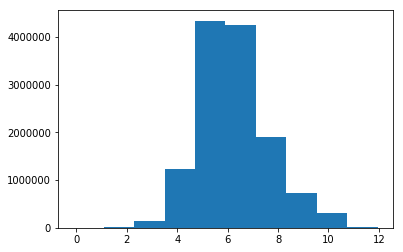

In [34]:
plt.hist(np.log10(model.mock.galaxy_table['stellar_mass']))
plt.show()

## Create sample with same distribution of $M_*$ as dwarf sample

In [35]:
print len(dwarf_masses)
print min(dwarf_masses), max(dwarf_masses)

6876
7.73324 8.99998


1190936


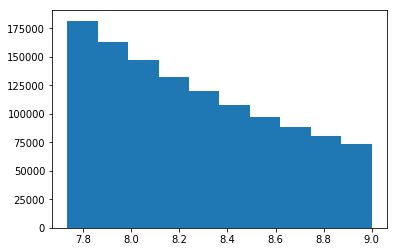

In [36]:
#galaxy table limited to mass range of dwarfs
mock_galaxies = model.mock.galaxy_table
mock_galaxies = mock_galaxies['galid', 'x', 'y', 'z', 'stellar_mass']
mock_galaxies = mock_galaxies[(np.log10(mock_galaxies['stellar_mass'])>=min(dwarf_masses)) & (np.log10(mock_galaxies['stellar_mass'])<9.0)]

print len(mock_galaxies)
plt.hist(np.log10(mock_galaxies['stellar_mass']))
plt.show()

In [37]:
mock_galaxies

galid,x,y,z,stellar_mass
int64,float32,float32,float32,float32
5,35.84579,43.34295,18.4178,94193460.0
15,35.9465,42.8824,18.21089,902417700.0
19,36.86769,43.22581,18.47096,63926256.0
47,36.10529,43.19333,18.27194,106955350.0
72,36.334,42.71314,18.11528,63037216.0
80,35.27654,43.45219,18.13028,415282560.0
105,35.72454,43.14617,17.92283,167300100.0
154,35.28469,43.02029,18.01919,75335496.0
170,36.96092,42.4537,18.58637,74440530.0


In [38]:
[list(a) for a in mock_galaxies[:10]]

[[5, 35.84579, 43.34295, 18.4178, 94193460.0],
 [15, 35.9465, 42.8824, 18.21089, 902417700.0],
 [19, 36.86769, 43.22581, 18.47096, 63926256.0],
 [47, 36.10529, 43.19333, 18.27194, 106955350.0],
 [72, 36.334, 42.71314, 18.11528, 63037216.0],
 [80, 35.27654, 43.45219, 18.13028, 415282560.0],
 [105, 35.72454, 43.14617, 17.92283, 167300100.0],
 [154, 35.28469, 43.02029, 18.01919, 75335496.0],
 [170, 36.96092, 42.4537, 18.58637, 74440530.0],
 [176, 35.47102, 43.3781, 18.2542, 54560924.0]]

In [70]:
%%time

def find_nearest_index(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    
    return idx


subsample=[]
copy_mock_galaxies = list(mock_galaxies)
gal_masses=[g[-1] for g in copy_mock_galaxies]

for dwarf in dwarf_masses[:10]:

    
    print '###############'
    #find index of mock galaxy with mass closes to dwarf
    %memit index = find_nearest_index(np.log10(gal_masses), dwarf)

    # append to subsample
    %memit subsample.append(copy_mock_galaxies[index])

    #do not replace in array of mock galaxy masses 
    #%memit copy_mock_galaxies = np.delete(copy_mock_galaxies, index)
    %memit del copy_mock_galaxies[index]
    %memit del gal_masses[index]

###############
peak memory: 1205.06 MiB, increment: 12.88 MiB
peak memory: 1205.06 MiB, increment: 0.00 MiB
peak memory: 1205.06 MiB, increment: 0.00 MiB
peak memory: 1205.06 MiB, increment: 0.00 MiB
###############
peak memory: 1205.06 MiB, increment: 0.00 MiB
peak memory: 1205.06 MiB, increment: 0.00 MiB
peak memory: 1205.06 MiB, increment: 0.00 MiB
peak memory: 1205.06 MiB, increment: 0.00 MiB
###############
peak memory: 1205.06 MiB, increment: 0.00 MiB
peak memory: 1205.06 MiB, increment: 0.00 MiB
peak memory: 1205.07 MiB, increment: 0.00 MiB
peak memory: 1205.07 MiB, increment: 0.00 MiB
###############
peak memory: 1205.07 MiB, increment: 0.00 MiB
peak memory: 1205.07 MiB, increment: 0.00 MiB
peak memory: 1205.07 MiB, increment: 0.00 MiB
peak memory: 1205.07 MiB, increment: 0.00 MiB
###############
peak memory: 1205.07 MiB, increment: 0.00 MiB
peak memory: 1205.07 MiB, increment: 0.00 MiB
peak memory: 1205.07 MiB, increment: 0.00 MiB
peak memory: 1205.07 MiB, increment: 0.00 MiB

In [71]:
# %%time
# def find_nearest_index(array,value):
#     differences = [t-value for t in array]
    
#     return differences.index(min(differences))

# subsample=[]
# copy_mock_galaxies = list(mock_galaxies)
# gal_masses=[g[-1] for g in copy_mock_galaxies]

# for dwarf in dwarf_masses[:10]:

    
#     print '###############'
#     #find index of mock galaxy with mass closes to dwarf
#     %memit index = find_nearest_index(np.log10(gal_masses), dwarf)

#     # append to subsample
#     %memit subsample.append(copy_mock_galaxies[index])

#     #do not replace in array of mock galaxy masses 
#     #%memit copy_mock_galaxies = np.delete(copy_mock_galaxies, index)
#     %memit del copy_mock_galaxies[index]
#     %memit del gal_masses[index]



###############
peak memory: 1212.24 MiB, increment: 24.14 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
###############
peak memory: 1214.50 MiB, increment: 21.97 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
###############
peak memory: 1211.43 MiB, increment: 18.90 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
###############
peak memory: 1214.42 MiB, increment: 21.89 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
peak memory: 1192.53 MiB, increment: 0.00 MiB
###############
peak memory: 1212.13 MiB, increment: 19.60 MiB
peak memory: 1192.61 MiB, increment: 0.00 MiB
peak memory: 1192.61 MiB, increment: 0.00 MiB
peak memory: 1192.61 MiB, increment: 0.00

In [ ]:
def find_nearest_index(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    
    return idx


subsample=[]
copy_mock_galaxies = list(mock_galaxies)
gal_masses=[g[-1] for g in copy_mock_galaxies]

In [ ]:
subsample=[]
copy_mock_galaxies = np.copy(mock_galaxies)

for i in range(1):
    print i
    
    for dwarf in dwarf_masses:
    
        #find index of mock galaxy with mass closes to dwarf
        index = find_nearest_index(np.log10(copy_mock_galaxies['stellar_mass']), dwarf)

        # append to subsample
        subsample.append(copy_mock_galaxies[index])

        #do not replace in array of mock galaxy masses 
        copy_mock_galaxies = np.delete(copy_mock_galaxies, index)

0
8.34463
8.54234
8.05947
8.44933
8.49875
8.96773
8.22163
8.2177
8.57805
8.801
8.53579
8.15993
8.4536
8.89182
8.96603
8.1984
8.6858
8.87099
8.47496
8.84171
8.46863
8.0032
8.7043
8.70386
7.98446
8.21807
8.44695
8.95177
8.58067
8.38835
8.62528
7.90337
8.4899
8.0197
8.20226
8.59608
8.98113
8.37229
8.38156
8.29772
8.60971
8.24669
8.71443
8.08236
8.61166
8.01013
8.93786
8.61148
8.94224
8.09933
8.48478
8.91673
8.52965
8.71793
8.75914
8.44939
8.47905
8.31385
8.39342
8.27933
8.38656
8.49251
8.98078
8.46024
8.90134
8.37353
8.33207
8.58315
8.37952
8.31335
8.11051
8.45514
8.98765
8.53462
8.62438
8.66306
8.3123
8.38124
8.96872
8.50373
8.867
8.89348
8.42087
8.50355
8.32745
8.2957
8.59034
8.90594
8.64289
8.42456
8.49621
8.85088
8.53624
8.803
8.61509
8.29269
8.81161
8.54467
8.97923
8.1467
8.59644
8.59714
8.98939
8.46566
8.47354
8.74147
8.54246
8.26616
8.75231
8.7535
8.28877
8.45523
8.33399
8.20011
8.54334
8.72418
8.27786
8.91034
8.44262
8.86038
8.18484
8.41389
8.87286
8.45586
8.60976
8.25197
8.98458


In [113]:
print len(subsample), len(copy_mock_galaxies), len(mock_galaxies)

68760 1122185 1190945


In [115]:
#check that they are indistinguishable
from scipy.stats import anderson_ksamp, ks_2samp

anderson_ksamp([subsample,dwarf_masses])
ks_2samp(subsample,dwarf_masses)

Ks_2sampResult(statistic=0.00058173356602675419, pvalue=0.99999999999999978)

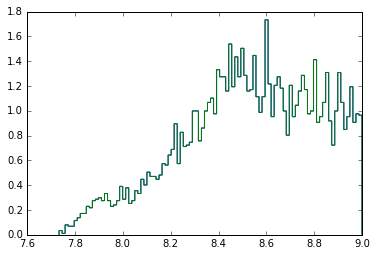

In [125]:
plt.hist(dwarf_masses, bins=100, histtype='step', normed=True)
plt.hist(subsample, bins=100, histtype='step', normed=True)
plt.show()

### 5/8: trying to figure out how to decrese the memory enough to run

In [80]:
subsample=[]
copy_mock_galaxies = [list(a) for a in mock_galaxies[:10]]
gal_masses=[g[-1] for g in copy_mock_galaxies]

for i in range(1):
    print i

    for dwarf in dwarf_masses[:5]:

        #find index of mock galaxy with mass closes to dwarf
        index = find_nearest_index(np.log10(gal_masses), dwarf)

        # append to subsample
        subsample.append(copy_mock_galaxies[index])

        #do not replace in array of mock galaxy masses 
        del copy_mock_galaxies[index]
        del gal_masses[index]

0


In [86]:
subsample_masses= [np.log10(s[-1]) for s in subsample]

In [87]:
subsample_masses

[7.7550149, 7.7778287, 7.8986411, 8.111166, 8.1713457]

In [88]:
len(dwarf_masses)

6876

## done in separate script 

In [39]:
#read in dwarf catalog
dwarf_galaxies_50 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_50.npy')
dwarf_galaxies_30 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_30.npy')
dwarf_galaxies_10 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_10.npy')
dwarf_galaxies_5 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_5.npy')
dwarf_galaxies_1 = np.load('/Users/fardila/Documents/GitHub/dwarf_lensing/bplanck_dwarfs_1.npy')

In [99]:
RP=[]
DS=[]

In [96]:
rp_bins+0.03415

array([0.04415   , 0.05193279, 0.06577278, 0.09038413, 0.13415   ,
       0.21197794, 0.35037777, 0.59649133, 1.03415   ])

In [100]:
for dwarf_galaxies in [dwarf_galaxies_5, dwarf_galaxies_10, dwarf_galaxies_30, dwarf_galaxies_50]:
    print len(dwarf_galaxies)
    
    x = [gal[1] for gal in dwarf_galaxies]
    y = [gal[2] for gal in dwarf_galaxies]
    z = [gal[3] for gal in dwarf_galaxies]
    galaxies = np.vstack((x, y, z)).T
    
    mass_encl = total_mass_enclosed_per_cylinder(galaxies, particles, particle_masses, downsampling_factor, rp_bins+0.03415, period)

    rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, rp_bins, period, cosmology=halocat.cosmology)
    ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2
    
    RP.append(rp)
    DS.append(ds)

34380
68760
206280
343800


In [102]:
def annular_area_weighted_midpoints(rp_bins):
    r""" Calculate the radius that bisects the areas a set of circles.

    Parameters
    ----------
    rp_bins : array_like
        Array of shape (num_circles, ) defining the input circles

    Returns
    -------
    rp_mids : array_like
        Array of shape (num_circles-1, ) defining the radii of annuli
        that subtend equal areas.

    Examples
    ---------
    >>> r_mids = annular_area_weighted_midpoints(np.linspace(0.1, 5, 10))
    """
    return np.sqrt(0.5*(rp_bins[:-1]**2 + rp_bins[1:]**2))

def reverse(bins):
    return (2*(np.sqrt(rp_bins+ rp_bins[1:]**2))**2

In [109]:
annular_area_weighted_midpoints(rp_bins+(10**0.03415))

array([1.09570584, 1.10653195, 1.12580324, 1.160131  , 1.22134159,
       1.33063598, 1.52606162, 1.87578624])

In [108]:
annular_area_weighted_midpoints(rp_bins)

array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
       0.2565373 , 0.45619501, 0.81124219])

In [79]:
rp_bins

array([0.01      , 0.01778279, 0.03162278, 0.05623413, 0.1       ,
       0.17782794, 0.31622777, 0.56234133, 1.        ])

In [98]:
RP

[array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
        0.2565373 , 0.45619501, 0.81124219]),
 array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
        0.2565373 , 0.45619501, 0.81124219]),
 array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
        0.2565373 , 0.45619501, 0.81124219]),
 array([0.01442615, 0.02565373, 0.0456195 , 0.08112422, 0.14426153,
        0.2565373 , 0.45619501, 0.81124219])]

In [74]:
cosmos_lensing_signal['R(Mpc)']

0.0133352
0.0237137
0.0421697
0.0749894
0.1333521
0.2371374
0.4216965
0.7498942


In [82]:
np.log10(rp - cosmos_lensing_signal['R(Mpc)'])

-2.9621940608101105
-2.7121914665488647
-2.4622060133879935
-2.212198280205067
-1.9621980417018086
-1.7122004210262984
-1.462199718946781
-1.2121996960421895


In [86]:
for i in range(len(rp)-1):
    print np.log10(rp[i+1]) - np.log10(rp[i])

0.25
0.2500000000000002
0.24999999999999978
0.2500000000000001
0.25
0.24999999999999994
0.25


In [87]:
for i in range(len(cosmos_lensing_signal['R(Mpc)']) -1):
    print np.log10(cosmos_lensing_signal['R(Mpc)'][i+1]) - np.log10(cosmos_lensing_signal['R(Mpc)'][i])

0.2499997877627953
0.25000119006307386
0.24999936736102835
0.24999998048824723
0.2500001946500353
0.24999994256373265
0.2499999981262017


In [90]:
print np.log10(cosmos_lensing_signal['R(Mpc)']) - np.log10(rp)
print 'mean: ', np.mean(np.log10(cosmos_lensing_signal['R(Mpc)']) - np.log10(rp))

        R(Mpc)       
---------------------
 -0.03415099262097887
 -0.03415120485818357
 -0.03415001479510993
 -0.03415064743408136
 -0.03415066694583424
 -0.03415047229579893
-0.034150529732066226
-0.034150531605864565
mean:  -0.03415063253598971


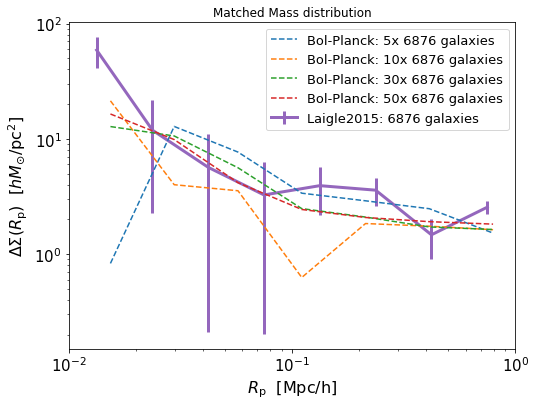

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.loglog()

for rp, ds, n in zip(RP,DS, [5,10,30,50]):
    ax.plot(rp, ds, label=r'Bol-Planck: ' +str(n)+ 'x '+str(len(dwarf_masses))+' galaxies', linestyle='--', zorder=3)
    ax.fill_between(rp, ds,ds, alpha=0.5)
# __=ax.plot(rp, result_mstar105_satellite_in_pc, label=r'Satellites: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_in_pc, label=r'All galaxies: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_central_in_pc, label=r'Centrals: $M_{\ast} \approx 10^{10.5}M_{\odot}$')

ax.errorbar(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)'], yerr=cosmos_lensing_signal['err(weights)'],
            label=r'Laigle2015: ' +str(len(dwarf_masses))+ ' galaxies', linewidth=3, zorder=1)
# ax.fill_between(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)']+cosmos_lensing_signal['err(weights)'],
#                 cosmos_lensing_signal['SigR(Msun/pc^2)']-cosmos_lensing_signal['err(weights)'], alpha=0.5)

__=ax.set_xlim(xmin = 0.01, xmax = 1)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.title('Matched Mass distribution')
plt.show()

## histogram

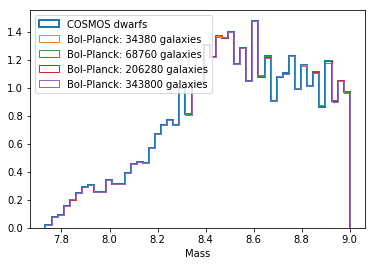

In [61]:

plt.hist(dwarf_masses, bins=50, histtype='step', normed=True, linewidth=2, label='COSMOS dwarfs')
for dwarf_galaxies in [dwarf_galaxies_5, dwarf_galaxies_10, dwarf_galaxies_30, dwarf_galaxies_50]:
    mock_masses = [np.log10(d[-1]) for d in dwarf_galaxies]
    plt.hist(mock_masses, bins=50, histtype='step', normed=True, label=r'Bol-Planck: ' +str(len(dwarf_galaxies))+ ' galaxies')
    
plt.xlabel('Mass')
plt.legend(loc='upper left')
plt.show()

# file for Alexie

In [118]:
rp_bins = np.logspace(-2, 1.3, 20)

In [119]:
dwarf_galaxies = dwarf_galaxies_50
print len(dwarf_galaxies)

x = [gal[1] for gal in dwarf_galaxies]
y = [gal[2] for gal in dwarf_galaxies]
z = [gal[3] for gal in dwarf_galaxies]
galaxies = np.vstack((x, y, z)).T

mass_encl = total_mass_enclosed_per_cylinder(galaxies, particles, particle_masses, downsampling_factor, rp_bins, period)

rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, rp_bins, period, cosmology=halocat.cosmology)
ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2

343800


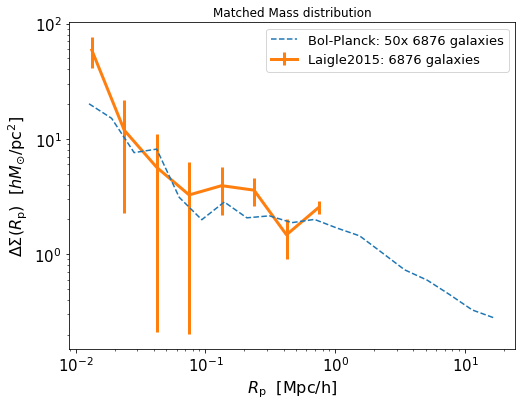

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.loglog()

ax.plot(rp, ds, label=r'Bol-Planck: ' +str(n)+ 'x '+str(len(dwarf_masses))+' galaxies', linestyle='--', zorder=3)
# ax.fill_between(rp, ds,ds, alpha=0.5)

ax.errorbar(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)'], yerr=cosmos_lensing_signal['err(weights)'],
            label=r'Laigle2015: ' +str(len(dwarf_masses))+ ' galaxies', linewidth=3, zorder=1)
# ax.fill_between(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)']+cosmos_lensing_signal['err(weights)'],
#                 cosmos_lensing_signal['SigR(Msun/pc^2)']-cosmos_lensing_signal['err(weights)'], alpha=0.5)

# __=ax.set_xlim(xmin = 0.01, xmax = 1)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.title('Matched Mass distribution')
plt.show()

In [124]:
from astropy.table import Table, Column
data = Table([rp, ds], names=['r', 'DS'])
ascii.write(data, 'BolPlanck_r_DS_50.txt')